In [73]:
# Basic libraries for image processing and visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt

(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

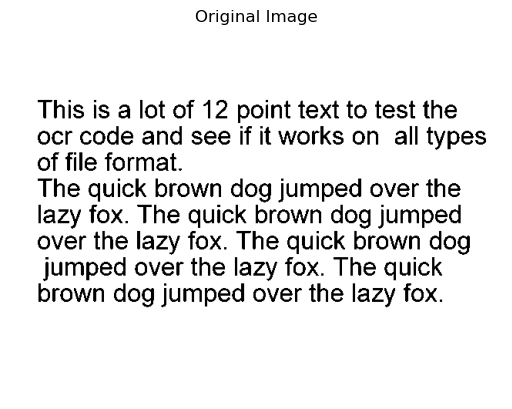

In [74]:
# Load image in grayscale
image_path = "document.png"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Display original image
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

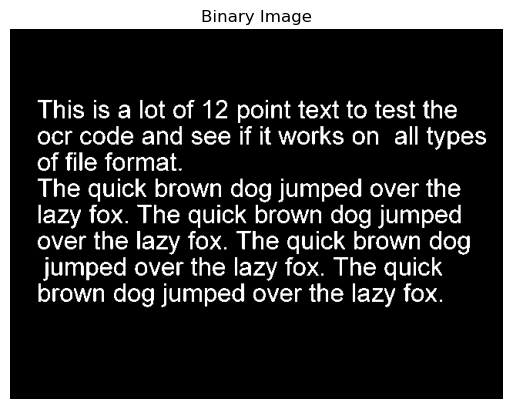

In [76]:
# Convert grayscale image to binary (OCR style)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary, cmap="gray")
plt.title("Binary Image")
plt.axis("off")

In [77]:
# Detect connected components
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary)
print("Total components detected:", num_labels - 1)

chars = []
boxes = []

# Extract each character
for i in range(1, num_labels):
    x, y, w, h, area = stats[i]
    
    if area < 10:   # Remove noise
        continue
        
    char = binary[y:y+h, x:x+w]
    char = cv2.resize(char, (20, 20))
    
    chars.append(char)
    boxes.append((x, y, w, h))

Total components detected: 239


In [78]:
threshold = 0.2   # Similarity threshold
groups = []
group_ids = []

for i in range(len(chars)):
    placed = False
    
    for g in range(len(groups)):
        diff = cv2.absdiff(chars[i], groups[g][0])
        mse = np.mean(diff) / 255.0
        
        if mse < threshold:
            groups[g].append(chars[i])
            group_ids.append(g)
            placed = True
            break
            
    if not placed:
        groups.append([chars[i]])
        group_ids.append(len(groups) - 1)

print("Unique symbol groups found:", len(groups))

Unique symbol groups found: 26


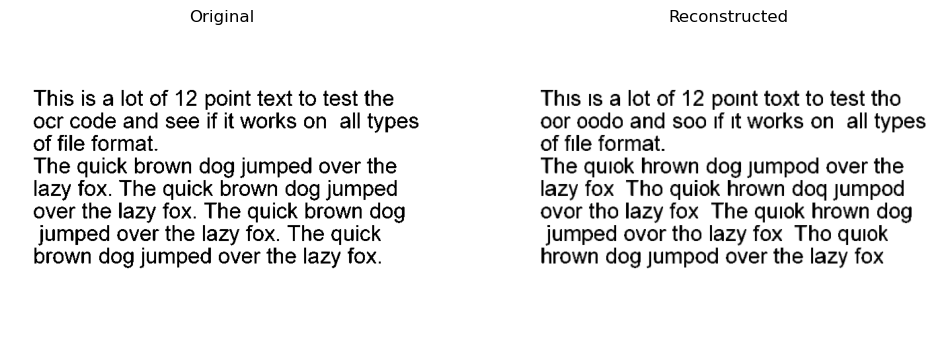

In [79]:
# Rebuild image using group prototypes
reconstructed = np.ones_like(img) * 255

for i in range(len(chars)):
    x, y, w, h = boxes[i]
    proto = groups[group_ids[i]][0]
    proto = cv2.resize(proto, (w, h))
    reconstructed[y:y+h, x:x+w] = 255 - proto

# Show original vs reconstructed
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(reconstructed, cmap="gray")
plt.axis("off")
plt.show()


# TASK 2 – Compression Impact

In [83]:
from skimage.metrics import structural_similarity as ssim

qualities = [90, 70, 50, 30]
compressed_images = {}

for q in qualities:
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), q]
    _, enc = cv2.imencode(".jpg", img, encode_param)
    dec = cv2.imdecode(enc, cv2.IMREAD_GRAYSCALE)
    compressed_images[q] = dec

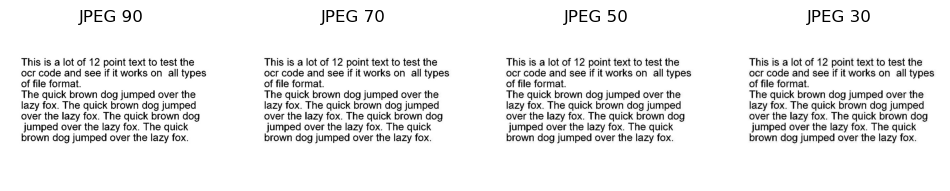

In [84]:
plt.figure(figsize=(12,6))
for i, q in enumerate(qualities):
    plt.subplot(1,4,i+1)
    plt.imshow(compressed_images[q], cmap="gray")
    plt.title(f"JPEG {q}")
    plt.axis("off")
plt.show()

In [85]:
def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(255.0 / np.sqrt(mse))

print("Quality | PSNR | SSIM")
print("-----------------------")
for q in qualities:
    p = psnr(img, compressed_images[q])
    s = ssim(img, compressed_images[q])
    print(f"{q:7} | {p:.2f} | {s:.4f}")

Quality | PSNR | SSIM
-----------------------
     90 | 45.15 | 0.9953
     70 | 38.54 | 0.9734
     50 | 37.53 | 0.9575
     30 | 36.67 | 0.9422


In [86]:
edges = {}

for q in qualities:
    edges[q] = cv2.Canny(compressed_images[q], 100, 200)

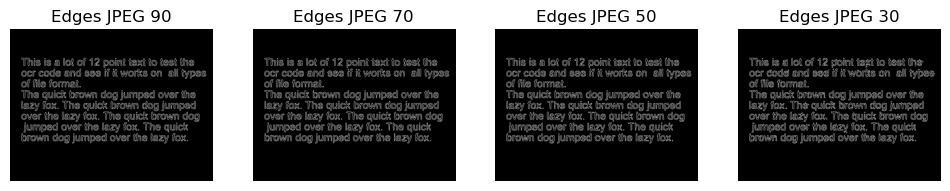

In [87]:
plt.figure(figsize=(12,6))

for i, q in enumerate(qualities):
    plt.subplot(1,4,i+1)
    plt.imshow(edges[q], cmap="gray")
    plt.title(f"Edges JPEG {q}")
    plt.axis("off")

plt.show()

## TASK 3 – Lossy vs Lossless

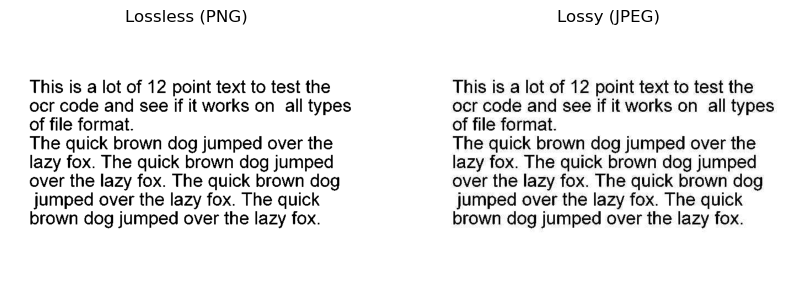

In [88]:
cv2.imwrite("doc_lossless.png", img)
img_lossless = cv2.imread("doc_lossless.png", cv2.IMREAD_GRAYSCALE)

cv2.imwrite("doc_lossy.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, 30])
img_lossy = cv2.imread("doc_lossy.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img_lossless, cmap="gray")
plt.title("Lossless (PNG)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_lossy, cmap="gray")
plt.title("Lossy (JPEG)")
plt.axis("off")
plt.show()

In [64]:
cv2.imwrite("doc_lossless.png", img)

img_lossless = cv2.imread("doc_lossless.png", cv2.IMREAD_GRAYSCALE)


In [65]:
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 30]  # LOW quality
cv2.imwrite("doc_lossy.jpg", img, encode_param)

img_lossy = cv2.imread("doc_lossy.jpg", cv2.IMREAD_GRAYSCALE)


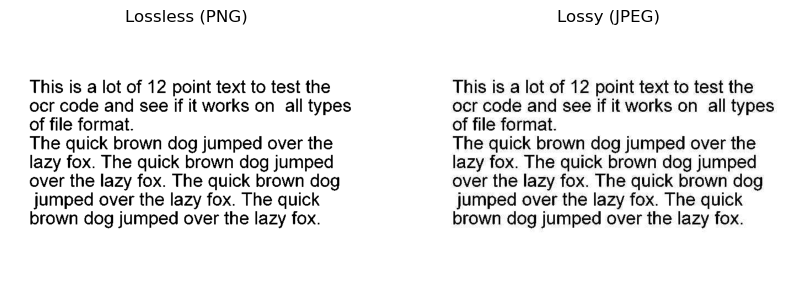

In [66]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img_lossless, cmap="gray")
plt.title("Lossless (PNG)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_lossy, cmap="gray")
plt.title("Lossy (JPEG)")
plt.axis("off")

plt.show()


In [91]:
# Function to count connected components in a binary image
# (used to estimate number of characters/objects)
def count_components(binary):
    num_labels, _, _, _ = cv2.connectedComponentsWithStats(binary)
    return num_labels - 1

In [92]:
# Convert lossless image to binary
_, bin_lossless = cv2.threshold(
    img_lossless, 127, 255, cv2.THRESH_BINARY
)

# Convert lossy image to binary
_, bin_lossy = cv2.threshold(
    img_lossy, 127, 255, cv2.THRESH_BINARY
)

print("Binary images created successfully")

Binary images created successfully


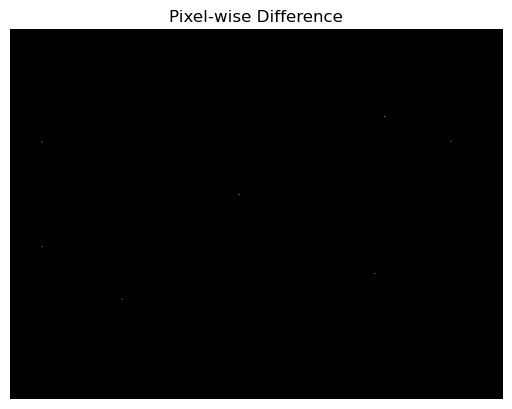

In [93]:
# Compute absolute pixel-wise difference between both binary images
diff = cv2.absdiff(bin_lossless, bin_lossy)

# Display difference image
plt.imshow(diff, cmap="gray")
plt.title("Pixel-wise Difference")
plt.axis("off")
plt.show()

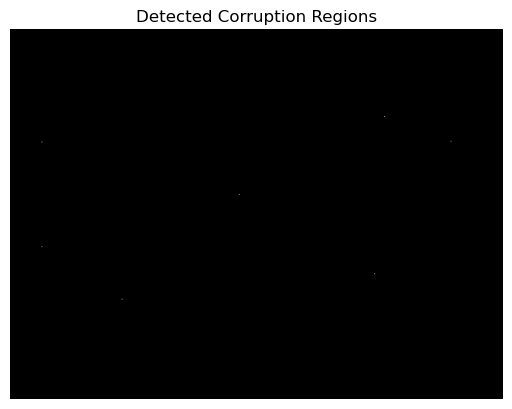

In [94]:
# Threshold difference image to highlight corrupted regions
_, diff_bin = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)

# Display detected corruption areas
plt.imshow(diff_bin, cmap="gray")
plt.title("Detected Corruption Regions")
plt.axis("off")
plt.show()

# Task 4 — OCR Accuracy on Compressed Image (Commented)

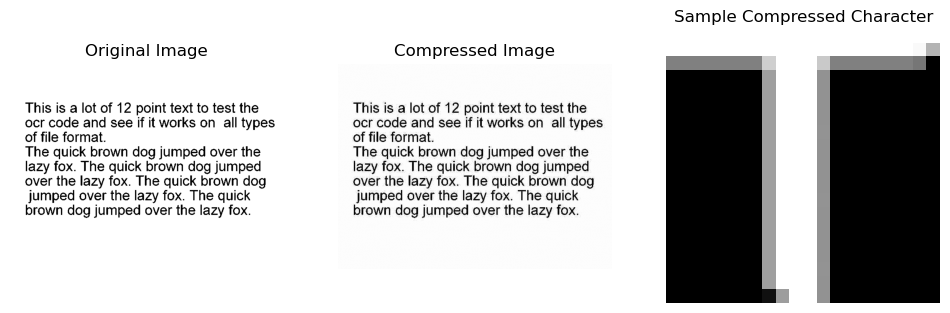

========== RESULTS ==========
Characters detected (Original): 220
Characters detected (Compressed): 220
Recognition Accuracy (Original):  0.92
Recognition Accuracy (Compressed): 0.92

Failures (Compressed Image):
{'I': 55, '-': 62, 'X': 17, 'O': 86}


In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. LOAD ORIGINAL IMAGE
# -------------------------------------------------
# Read the original document image in grayscale
img = cv2.imread("document.png", cv2.IMREAD_GRAYSCALE)

# -------------------------------------------------
# 2. CREATE HEAVILY COMPRESSED IMAGE
# -------------------------------------------------
# Save the image with very low JPEG quality (20)
cv2.imwrite("doc_compressed.jpg", img, [cv2.IMWRITE_JPEG_QUALITY, 20])

# Read the compressed image
img_comp = cv2.imread("doc_compressed.jpg", cv2.IMREAD_GRAYSCALE)

# -------------------------------------------------
# 3. BINARIZATION (OCR STYLE)
# -------------------------------------------------
# Convert original image to binary
_, bin_orig = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

# Convert compressed image to binary
_, bin_comp = cv2.threshold(img_comp, 127, 255, cv2.THRESH_BINARY_INV)

# -------------------------------------------------
# 4. CHARACTER EXTRACTION
# -------------------------------------------------
# Function to extract characters using connected components
def extract_chars(binary):
    num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary)
    chars = []
    
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        
        # Ignore very small components (noise)
        if area > 20:
            roi = binary[y:y+h, x:x+w]
            roi = cv2.resize(roi, (20, 20))
            chars.append(roi)
    
    return chars

# Extract characters from original and compressed images
chars_orig = extract_chars(bin_orig)
chars_comp = extract_chars(bin_comp)

# -------------------------------------------------
# 5. RULE-BASED CHARACTER RECOGNIZER
# -------------------------------------------------
# Simple heuristic-based recognizer
def recognize_char(img):
    # Count vertical strokes
    vertical = np.sum(img[:, 9:11] > 0)
    
    # Count horizontal strokes
    horizontal = np.sum(img[9:11, :] > 0)
    
    # Detect contours to find holes (like in 'O')
    contours, hierarchy = cv2.findContours(
        img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE
    )
    
    holes = 0
    if hierarchy is not None:
        for h in hierarchy[0]:
            if h[3] != -1:
                holes += 1

    # Decision rules
    if holes >= 1:
        return "O"
    elif vertical > horizontal:
        return "I"
    elif horizontal > vertical:
        return "-"
    else:
        return "X"   # unknown / failure

# -------------------------------------------------
# 6. RECOGNITION
# -------------------------------------------------
# Predict characters for both images
pred_orig = [recognize_char(c) for c in chars_orig]
pred_comp = [recognize_char(c) for c in chars_comp]

# -------------------------------------------------
# 7. ACCURACY MEASUREMENT
# -------------------------------------------------
# Function to compute recognition accuracy
def accuracy(pred):
    correct = sum(1 for p in pred if p != "X")
    return correct / len(pred) if len(pred) > 0 else 0

# Accuracy for original and compressed images
acc_orig = accuracy(pred_orig)
acc_comp = accuracy(pred_comp)

# -------------------------------------------------
# 8. FAILURE ANALYSIS
# -------------------------------------------------
# Count how many times each symbol was predicted
failures = {}
for p in pred_comp:
    failures[p] = failures.get(p, 0) + 1

# -------------------------------------------------
# 9. VISUAL COMPARISON
# -------------------------------------------------
# Show original image, compressed image, and one sample character
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(img_comp, cmap="gray")
plt.title("Compressed Image")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(chars_comp[0], cmap="gray")
plt.title("Sample Compressed Character")
plt.axis("off")

plt.show()

# -------------------------------------------------
# 10. PRINT RESULTS
# -------------------------------------------------
print("========== RESULTS ==========")
print("Characters detected (Original):", len(chars_orig))
print("Characters detected (Compressed):", len(chars_comp))
print("Recognition Accuracy (Original): ", round(acc_orig, 2))
print("Recognition Accuracy (Compressed):", round(acc_comp, 2))
print("\nFailures (Compressed Image):")
print(failures)

# TASK 5 – Safe Compression Decision System

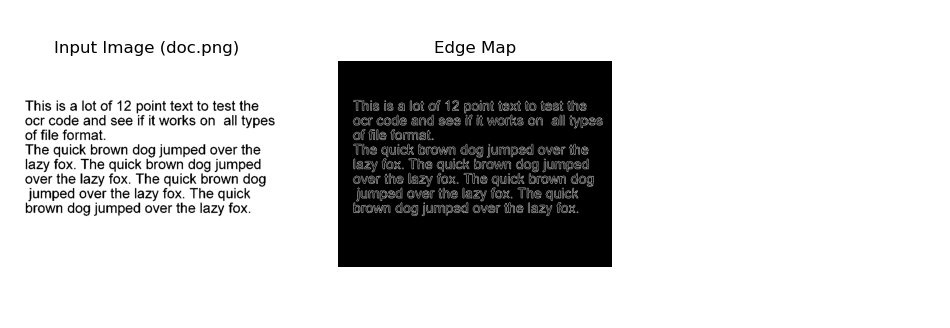

===== SAFE COMPRESSION ANALYSIS =====
Image: document.png
Entropy: 0.45
Edge Density: 0.061
Connected Components: 239
Final Decision: NO COMPRESSION
Reason: Critical document (forms / fine lines)


In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import shannon_entropy

# ---------------------------------------------
# LOAD IMAGE (doc.png)
# ---------------------------------------------
# Path of the input document image
image_path = "document.png"

# Read the image in grayscale mode
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Safety check: ensure image is loaded correctly
if img is None:
    raise ValueError("doc.png not found!")

# ---------------------------------------------
# 1. ENTROPY
# ---------------------------------------------
# Compute Shannon entropy to measure information content
# Higher entropy = more complex image
entropy = shannon_entropy(img)

# ---------------------------------------------
# 2. EDGE DENSITY
# ---------------------------------------------
# Apply Canny edge detector to find structural details
edges = cv2.Canny(img, 100, 200)

# Calculate edge density as ratio of edge pixels
edge_density = np.sum(edges > 0) / edges.size

# ---------------------------------------------
# 3. CONNECTED COMPONENT COUNT
# ---------------------------------------------
# Convert image to binary (OCR-style)
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

# Count connected components (characters/objects)
num_labels, _, stats, _ = cv2.connectedComponentsWithStats(binary)

# Subtract background component
cc_count = num_labels - 1

# ---------------------------------------------
# 4. SAFE COMPRESSION DECISION RULE
# ---------------------------------------------
# Rule-based decision system for compression strategy
if cc_count > 500 and edge_density > 0.05:
    decision = "LOSSLESS COMPRESSION"
    reason = "Text-heavy document with many characters"

elif edge_density > 0.04 and entropy < 5:
    decision = "NO COMPRESSION"
    reason = "Critical document (forms / fine lines)"

else:
    decision = "LOSSY COMPRESSION"
    reason = "Low risk of structural damage"

# ---------------------------------------------
# 5. SHOW RESULTS
# ---------------------------------------------
# Visualize input image and its edge map
plt.figure(figsize=(12,4))

# Original image
plt.subplot(1,3,1)
plt.imshow(img, cmap="gray")
plt.title("Input Image (doc.png)")
plt.axis("off")

# Edge map
plt.subplot(1,3,2)
plt.imshow(edges, cmap="gray")
plt.title("Edge Map")
plt.axis("off")

# Empty placeholder (for layout consistency)
plt.subplot(1,3,3)
plt.axis("off")

plt.show()

# ---------------------------------------------
# 6. PRINT SUMMARY (FOR EXAM OUTPUT)
# ---------------------------------------------
# Final report for decision making
print("===== SAFE COMPRESSION ANALYSIS =====")
print("Image:", image_path)
print("Entropy:", round(entropy, 2))
print("Edge Density:", round(edge_density, 3))
print("Connected Components:", cc_count)
print("Final Decision:", decision)
print("Reason:", reason)